In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import math
import time
import scipy.stats as stats
from tqdm import tqdm

from collections import defaultdict
from scipy.stats.stats import pearsonr

## Loading the dataset

In [2]:
df = pd.read_csv("../dataset/customer_supermarket.csv", sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")

## Attributes and check

In [ ]:
df.dtypes

In [ ]:
df.isna().any()
df_temp = df[df.isnull().any(axis=1)]

In [ ]:
print(len(df_temp))

Here we can have an idea of data types we are going to use

| Attribute       | Type       |
|-----------------|------------|
| BasketID        | int64      |
| BasketDate      | datetime64 |
| Sale            | float64    |
| CustomerID      | int64      |
| CustomerCountry | object     |
| ProdID          | object     |
| ProdDescr       | object     |
| Qta             | int64      |

as we can see there are problems in the attribute values, so we have to evaluate what prevents us from getting the desired data types:

The execution df['BasketID'].astype(int) tell us that some rows contains literal inside the attribute BasketID, this means the data type cannot be converted to int

## Checking NaN values and duplicates

It is possible to evaluate the quality of the data from the point of view of the rows, based on two aspects:
- missing or partial value (NaN/Null values)
- duplicates
- duplicates products in the same basket

Any duplicates or rows with missing values are temporarily removed from the dataset to allow for better evaluation

In [22]:
# check if there are duplicates
areduplicates = df.duplicated().any()

# rows with nan values before dropping duplicates
df_nan_only = df[df.isnull().any(axis=1)]
# duplicates have been removed from the data set
df_nodup = df.drop_duplicates()

# check if there are missing or incomplete values
arenan = df.isnull().values.any()

# rows with missing or incomplete values have been removed from the data set
df_nan_only.to_csv("../dataset/customer_supermarket_nan.csv", sep="\t", decimal=",")
df_clean = df_nodup.dropna()

print("Duplicate rows in the dataset: ", areduplicates, "| Number or rows removed: ", len(df)-len(df_nodup))
print("NaN/Null values in the dataset: ", arenan, "| Number or rows removed: ", len(df_nodup)-len(df_clean))

nmb_of_rmv_rows = len(df)-len(df_clean)

print(f"Number of rows with apparent problems to solve: {100*nmb_of_rmv_rows/len(df):.3f}%")


df_Sale_Qta_merge = df_clean.groupby(['BasketID','BasketDate','ProdID']).agg({'Qta':np.sum,
                                                                         'Sale':np.sum,
                                                                         'CustomerID':'min',
                                                                         'CustomerCountry':'min',
                                                                         'ProdDescr':'min'}).reset_index()

df_Sale_Qta_merge.to_csv("../dataset/customer_supermarket_sale_qta_merge.csv", sep="\t", decimal=",")

print(f"Number of identical items in multiple rows of the same receipt {len(df_clean) - len(df_Sale_Qta_merge)}")

Duplicate rows in the dataset:  True | Number or rows removed:  5232
NaN/Null values in the dataset:  True | Number or rows removed:  65073
Number of rows with apparent problems to solve: 14.898%
Number of identical items in multiple rows of the same receipt 4918


## Checking data consistency

Here we are verifing that the dataset is consistent:

1. Every ProdID must match the same ProdDescr
2. Every CustomerID must match the same BasketID in the same BasketDate
3. Every CustomerID must match the same CustomerCountry

In [4]:
def inconsistent_set(K,V):
    
    inconsistentset = list()

    for key in tqdm(df_Sale_Qta_merge[K].unique().tolist()):
        temp_df = df_Sale_Qta_merge[df_Sale_Qta_merge[K] == key]
        valueslist = temp_df[V].tolist()
        for value in valueslist:
            if(valueslist[0] != value):
                inconsistentset.append(key)
                break;
    return inconsistentset


# 1
ProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")
            
print("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))

with open('../dataset/inconsistent_ProdID_ProdDescr.json', 'w') as f:
    json.dump(ProdID_ProdDescr_IS, f, sort_keys=True)


#2 True == no error
temp = df_Sale_Qta_merge.groupby(['BasketID','BasketDate']).CustomerID.nunique().eq(1)
print("Every CustomerID matches the same BasketID in the same BasketDate: ", temp.all())

#to avoid graphical printing bug
time.sleep(0.1)
#3 
CustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")
            
print("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))


with open('../dataset/inconsistent_CustomerID_CustomerCountry.json', 'w') as f:
    json.dump(CustomerID_CustomerCountry_IS, f, sort_keys=True)

100%|██████████| 3684/3684 [01:21<00:00, 45.32it/s]


Number of not consistent ProdDescr: 213
Every CustomerID matches the same BasketID in the same BasketDate:  True


100%|██████████| 4372/4372 [01:36<00:00, 45.47it/s]

Number of not consistent CustomerCountry: 8


## Converting attributes to correct data type

Here we are changing the type of attributes. This imply a little cleaning phase over BasketID because there are characters inside the values

In [5]:
df_Sale_Qta_merge['CustomerID'] = pd.to_numeric(df_Sale_Qta_merge.CustomerID)
df_Sale_Qta_merge.CustomerID = df_Sale_Qta_merge.CustomerID.astype(int)

The only attribute that still has a wrong datatype is BasketID, we have to remove letters at the beginning of the ID.

In [6]:
# regex matchin everything except digits
regex = "\D+"
df_regex = pd.DataFrame(df_Sale_Qta_merge)
df_regex['BasketID'] = df_regex['BasketID'].replace(to_replace=r'\D+', value='', regex=True)
df_regex.BasketID = pd.to_numeric(df_regex.BasketID)
df_regex.info()
df_regex.to_csv("../dataset/customer_supermarket_regex.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396687 entries, 0 to 396686
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         396687 non-null  int64         
 1   BasketDate       396687 non-null  datetime64[ns]
 2   ProdID           396687 non-null  object        
 3   Qta              396687 non-null  int64         
 4   Sale             396687 non-null  float64       
 5   CustomerID       396687 non-null  int64         
 6   CustomerCountry  396687 non-null  object        
 7   ProdDescr        396687 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 24.2+ MB


## Statistics and data understanding (maybe Data preparation???)

Here are informations about quantities

In [7]:
print("Number of clients: ",len(df_regex['CustomerID'].unique()))
print("Number of products: ",len(df_regex['ProdID'].unique()))
print("Number of purchase: ",len(df_regex['BasketID'].unique()))
print("Distinct values in Customer Country: \t", len(df_regex.CustomerCountry.unique()))
#print("Distinct values in ProdID: \t", df_clean.ProdID.unique())
#print("Distinct values in ProdDescr: \t", df_clean.ProdDescr.unique())

Number of clients:  4372
Number of products:  3684
Number of purchase:  22190
Distinct values in Customer Country: 	 37


We have people coming from unspecified countries, a generic "European Community", EIRE which stands for Ireland and RSA which stands for Republic of South Africa.

In [8]:
print("Number of customers from Unspecified countries: \t", (df_clean.CustomerCountry == "Unspecified").sum())
print("Number of customers from generic European Community countries: \t", (df_clean.CustomerCountry == "European Community").sum())


Number of customers from Unspecified countries: 	 241
Number of customers from generic European Community countries: 	 61


In [9]:
df_regex.describe()

,BasketID,Qta,Sale,CustomerID
count,396687.000000,396687.000000,396687.000000,396687.000000
mean,560515.658628,12.334289,3.517171,15275.508817
std,13069.338881,251.837689,71.148484,1714.300274
min,536365.000000,-80995.000000,0.000000,12346.000000
25%,549127.500000,2.000000,1.250000,13923.000000
50%,561704.000000,6.000000,1.950000,15133.000000
75%,571913.000000,12.000000,3.750000,16779.000000
max,581587.000000,80995.000000,38970.000000,18287.000000


## Correlation

### Correlation matrix

There seems to be absolutely no correlation between the values of the dataset

In [10]:
correlations = df_regex.corr(method="pearson")
correlations

,BasketID,Qta,Sale,CustomerID
BasketID,1.000000,-0.001540,-0.002382,0.000196
Qta,-0.001540,1.000000,-0.001248,-0.003316
Sale,-0.002382,-0.001248,1.000000,-0.004328
CustomerID,0.000196,-0.003316,-0.004328,1.000000


<AxesSubplot:>

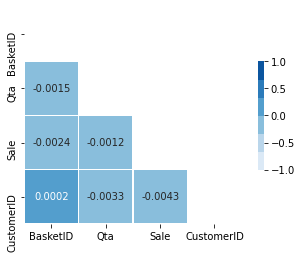

In [11]:
import seaborn as sns

mask = np.triu(np.ones_like(correlations, dtype=bool))

# this diverging palette is pretty dull since everything is unrelated
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

cmap = sns.color_palette("Blues")
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})

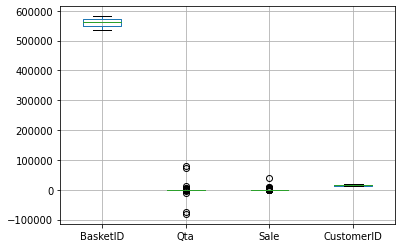

In [12]:
boxplot = df_regex.boxplot()

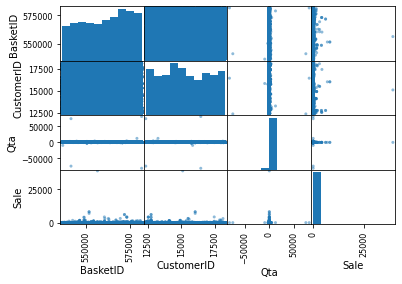

In [13]:
pd.plotting.scatter_matrix(df_regex[['BasketID', 'CustomerID', 'Qta', 'Sale']])
plt.show()

<class 'pandas.core.frame.DataFrame'>


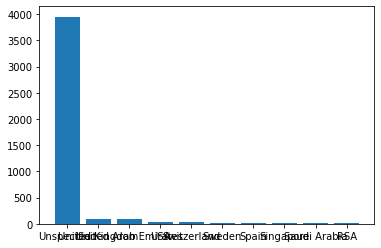

In [19]:
temp = df_regex.groupby('CustomerCountry').CustomerID.nunique().reset_index()
print(type(temp))
#temp.plot(kind='bar', title='Size Counts')
plt.bar(temp['CustomerCountry'].sort_values(ascending=False)[:10],temp['CustomerID'].sort_values(ascending=False)[:10])
plt.show()

Scatterplot shows irregular Qta and Sale, probably outliers

In [20]:
qta_std = df_regex['Qta'].std()
qta_mean = df_regex['Qta'].mean()

sale_std = df_regex['Sale'].std()
sale_mean = df_regex['Sale'].mean()

print("QTA STD: ", qta_std, " QTA MEAN: ", qta_mean)
print("SALE STD: ", sale_std, " SALE MEAN: ", sale_mean)

threshold = 3

def outliers_zscore(qta,sale):
    
    qta_z_score = (qta - qta_mean) / qta_std
    if(np.abs(qta_z_score) > threshold):
        return True
    
    sale_z_score = (sale - sale_mean) / sale_std
    if(np.abs(sale_z_score) > threshold):
        return True
    
    return False
    
df_regex['Outlier'] = df_regex.apply(lambda x: outliers_zscore(x['Qta'],x['Sale']), axis=1)



QTA STD:  251.83768934373637  QTA MEAN:  12.334288746543244
SALE STD:  71.14848439529611  SALE MEAN:  3.5171706004986305


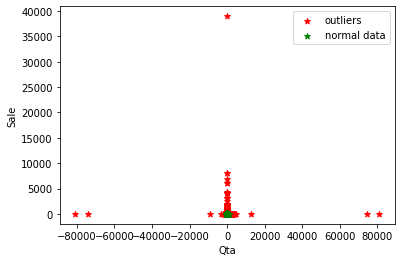

In [21]:
outliers_df = df_regex[df_regex['Outlier'] == True]
notoutliers_df = df_regex[df_regex['Outlier'] == False]

plt.scatter(outliers_df['Qta'],outliers_df['Sale'], color='r', marker='*', label="outliers")

plt.scatter(notoutliers_df['Qta'],notoutliers_df['Sale'], color='g', marker='*', label="normal data")


plt.xlabel('Qta')
plt.ylabel('Sale')
plt.legend()
plt.show()